In [1]:
import pandas as pd
import numpy as np
import os

results_dir = "Analyzer Results"

input_dir = "TT Input"

""" output_dir = "Top Tester Results"

os.makedirs(output_dir, exist_ok=True) """

' output_dir = "Top Tester Results"\n\nos.makedirs(output_dir, exist_ok=True) '

In [2]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_MERGED', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MTT', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_TT', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder']
Fit dataframes: ['RESULTS_FIT', 'RESULTS_MERGED_DATE_FIT', 'RESULTS_MERGED_EXP_FIT', 'RESULTS_MERGED_FIT', 'RESULTS_MT10_FIT', 'RESULTS_MTT_FIT', 'RESULTS_MTT_MERGED_DATE_FIT', 'RESULTS_MTT_MERGED_EXP_FIT', 'RESULTS_MTT_MERGED_FIT', 'RESULTS_T10_FIT', 'RESULTS_TT_FIT', 'RESULTS_TT_MERGED_DATE_FIT', 'RESULTS_TT_MERGED_EXP_FIT', 'RESULTS_TT_MERGED_FIT', 'SegmentOrder_FIT']
Found 15 raw and 15 fit dataframes in Analyzer Results.

Found 18 experiments, 9 variables and 4 parameters:
 ASR_control, gap_depth, tone_in_noise, gap_duration_4, gap_duration_8, gap_duration_10, gap_duration_20, gap_duration_50, offset_PPI_4, offset_PPI_6, offset_PPI_8, offset_PPI_10, offset_PPI_12, offset_P

In [3]:
# ...existing code...
before = len(dfs)
files = [file for file in os.listdir(input_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(input_dir, file)
    key = file.split('.')[0]
    dfs[key] = pd.read_excel(file_path)
    print(f"Loaded {file} into dataframe with key '{key}'.")

print("All dataframes:", list(dfs.keys()))

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Loaded C10.xlsx into dataframe with key 'C10'.
Loaded C20.xlsx into dataframe with key 'C20'.
Loaded C30.xlsx into dataframe with key 'C30'.
Loaded C40.xlsx into dataframe with key 'C40'.
Loaded C50.xlsx into dataframe with key 'C50'.
Loaded CM10.xlsx into dataframe with key 'CM10'.
Loaded CM20.xlsx into dataframe with key 'CM20'.
Loaded CM30.xlsx into dataframe with key 'CM30'.
Loaded CM40.xlsx into dataframe with key 'CM40'.
Loaded CM50.xlsx into dataframe with key 'CM50'.
Loaded RESULTS_MT10.xlsx into dataframe with key 'RESULTS_MT10'.
Loaded RESULTS_MT20.xlsx into dataframe with key 'RESULTS_MT20'.
Loaded RESULTS_MT30.xlsx into dataframe with key 'RESULTS_MT30'.
Loaded RESULTS_MT40.xlsx into dataframe with key 'RESULTS_MT40'.
Loaded RESULTS_MT50.xlsx into dataframe with key 'RESULTS_MT50'.
Loaded RESULTS_T10.xlsx into dataframe with key 'RESULTS_T10'.
Loaded RESULTS_T20.xlsx into dataframe with key 'RESULTS_T20'.
Loaded RESULTS_T30.xlsx into dataframe with key 'RESULTS_T30'.
Loaded

In [4]:
# ...existing code...

from scipy.stats import mannwhitneyu

def compare_dataframes(df1, df2, parameters, variables):
    results = []
    # Get all unique parameter combinations in df1
    param_combos = df1[parameters].drop_duplicates()
    for _, combo in param_combos.iterrows():
        # Filter both dataframes for this parameter combo
        mask1 = (df1[parameters] == combo.values).all(axis=1)
        mask2 = (df2[parameters] == combo.values).all(axis=1)
        if mask1.sum() == 0 or mask2.sum() == 0:
            continue  # Skip if combo not present in both
        for var in variables:
            data1 = df1.loc[mask1, var].dropna()
            data2 = df2.loc[mask2, var].dropna()
            if len(data1) < 2 or len(data2) < 2:
                continue  # Need at least 2 samples for Mann-Whitney
            stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
            results.append({
                **dict(zip(parameters, combo.values)),
                'variable': var,
                'statistic': stat,
                'p_value': p,
                'n_df1': len(data1),
                'n_df2': len(data2)
            })
    return pd.DataFrame(results)

In [5]:
# ...existing code...

import ast

def flatten_column(col):
    # Flattens a column of lists, stringified lists, or scalars into a single list of numbers
    out = []
    for item in col.dropna():
        if isinstance(item, list):
            out.extend(item)
        elif isinstance(item, str):
            try:
                parsed = ast.literal_eval(item)
                if isinstance(parsed, list):
                    out.extend(parsed)
                elif isinstance(parsed, (int, float, np.integer, np.floating)):
                    out.append(parsed)
            except Exception:
                continue  # Ignore strings that can't be parsed
        elif isinstance(item, (int, float, np.integer, np.floating)):
            out.append(item)
        # Ignore non-numeric, non-list
    return pd.Series(out)

# ...existing code...

def compare_general_trends(df1, df2, variables):
    summary = []
    for var in variables:
        flat1 = flatten_column(df1[var])
        flat2 = flatten_column(df2[var])
        if len(flat1) > 0 and len(flat2) > 0:
            mean_diff = flat1.mean() - flat2.mean()
            stats = {
                'mean_difference': mean_diff,
                'df1_median': flat1.median(),
                'df1_std': flat1.std(),
                'df1_n': flat1.count(),
                'df2_median': flat2.median(),
                'df2_std': flat2.std(),
                'df2_n': flat2.count(),
            }
            summary.append({
                'variable': var,
                **stats
            })
        else:
            summary.append({
                'variable': var,
                'mean_difference': 'no data',
                'df1_median': 'no data',
                'df1_std': 'no data',
                'df1_n': len(flat1),
                'df2_median': 'no data',
                'df2_std': 'no data',
                'df2_n': len(flat2),
            })
    return pd.DataFrame(summary)


from scipy.stats import mannwhitneyu

def test_general_trend_significance(df1, df2, variables):
    results = []
    for var in variables:
        flat1 = flatten_column(df1[var])
        flat2 = flatten_column(df2[var])
        if len(flat1) > 1 and len(flat2) > 1:
            stat, p = mannwhitneyu(flat1, flat2, alternative='two-sided')
            results.append({
                'variable': var,
                'n_df1': len(flat1),
                'n_df2': len(flat2),
                'statistic': stat,
                'p_value': p
            })
        else:
            results.append({
                'variable': var,
                'n_df1': len(flat1),
                'n_df2': len(flat2),
                'statistic': 'no data',
                'p_value': 'no data'
            })
    return pd.DataFrame(results)

# ...existing code...

In [6]:
# ...existing code...

def compare_general_trends_by_sex(df1, df2, variables):
    summary = []
    sexes = sorted(set(df1['sex'].dropna().unique()).union(df2['sex'].dropna().unique()))
    for sex in sexes:
        df1_sex = df1[df1['sex'] == sex]
        df2_sex = df2[df2['sex'] == sex]
        for var in variables:
            flat1 = flatten_column(df1_sex[var]) if var in df1_sex else pd.Series([])
            flat2 = flatten_column(df2_sex[var]) if var in df2_sex else pd.Series([])
            if len(flat1) > 0 and len(flat2) > 0:
                mean_diff = flat1.mean() - flat2.mean()
                stats = {
                    'sex': sex,
                    'variable': var,
                    'mean_difference': mean_diff,
                    'df1_median': flat1.median(),
                    'df1_std': flat1.std(),
                    'df1_n': flat1.count(),
                    'df2_median': flat2.median(),
                    'df2_std': flat2.std(),
                    'df2_n': flat2.count(),
                }
                summary.append(stats)
            else:
                summary.append({
                    'sex': sex,
                    'variable': var,
                    'mean_difference': 'no data',
                    'df1_median': 'no data',
                    'df1_std': 'no data',
                    'df1_n': len(flat1),
                    'df2_median': 'no data',
                    'df2_std': 'no data',
                    'df2_n': len(flat2),
                })
    return pd.DataFrame(summary)

def test_general_trend_significance_by_sex(df1, df2, variables):
    results = []
    sexes = sorted(set(df1['sex'].dropna().unique()).union(df2['sex'].dropna().unique()))
    for sex in sexes:
        df1_sex = df1[df1['sex'] == sex]
        df2_sex = df2[df2['sex'] == sex]
        for var in variables:
            flat1 = flatten_column(df1_sex[var]) if var in df1_sex else pd.Series([])
            flat2 = flatten_column(df2_sex[var]) if var in df2_sex else pd.Series([])
            if len(flat1) > 1 and len(flat2) > 1:
                stat, p = mannwhitneyu(flat1, flat2, alternative='two-sided')
                results.append({
                    'sex': sex,
                    'variable': var,
                    'n_df1': len(flat1),
                    'n_df2': len(flat2),
                    'statistic': stat,
                    'p_value': p
                })
            else:
                results.append({
                    'sex': sex,
                    'variable': var,
                    'n_df1': len(flat1),
                    'n_df2': len(flat2),
                    'statistic': 'no data',
                    'p_value': 'no data'
                })
    return pd.DataFrame(results)


In [7]:
df1 = dfs['RESULTS_T10']
df2 = dfs['RESULTS_MT10']

In [8]:
result_df = compare_dataframes(df1, df2, parameters, variables)
print(result_df)

Empty DataFrame
Columns: []
Index: []


In [9]:
trend_df = compare_general_trends(df1, df2, variables)
print(trend_df)

       variable  mean_difference  df1_median      df1_std  df1_n  df2_median  \
0  reactionTime        -0.343295       10.00     1.951810    171       10.00   
1      peakTime         0.078816       30.00     6.633581    171       30.00   
2    difference         0.422111       20.00     6.921547    171       20.00   
3     peakValue        17.664747      138.00    63.514900    171      113.00   
4          PTPA        17.037672      138.16    62.497836    171      113.69   
5          PTTA        15.580123      124.08    57.929477    171      100.61   
6           RMS         5.757767       48.49    24.497296    171       44.20   
7           tau        -9.996915      128.32    53.181116    171      140.81   
8           AUC       851.252639    11856.75  6113.397730    171    10704.35   

       df2_std  df2_n  
0     1.989860   1447  
1     4.912407   1447  
2     5.310162   1447  
3    60.770962   1447  
4    60.128009   1447  
5    55.742306   1447  
6    24.472297   1447  
7    49

In [10]:
print("Top 10:")
trend_df = compare_general_trends(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(sig_df)

Top 10:
       variable  mean_difference  df1_median      df1_std  df1_n  df2_median  \
0  reactionTime        -0.343295       10.00     1.951810    171       10.00   
1      peakTime         0.078816       30.00     6.633581    171       30.00   
2    difference         0.422111       20.00     6.921547    171       20.00   
3     peakValue        17.664747      138.00    63.514900    171      113.00   
4          PTPA        17.037672      138.16    62.497836    171      113.69   
5          PTTA        15.580123      124.08    57.929477    171      100.61   
6           RMS         5.757767       48.49    24.497296    171       44.20   
7           tau        -9.996915      128.32    53.181116    171      140.81   
8           AUC       851.252639    11856.75  6113.397730    171    10704.35   

       df2_std  df2_n  
0     1.989860   1447  
1     4.912407   1447  
2     5.310162   1447  
3    60.770962   1447  
4    60.128009   1447  
5    55.742306   1447  
6    24.472297   1447  

In [11]:
print("Top 10:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(sig_df)

Top 10:
       sex      variable  mean_difference  df1_median      df1_std  df1_n  \
0   female  reactionTime        -0.530487      10.000     2.053325     86   
1   female      peakTime        -0.185728      30.000     4.620835     86   
2   female    difference         0.344759      20.000     5.150538     86   
3   female     peakValue        14.493023      95.000    36.875188     86   
4   female          PTPA        13.973608      94.900    35.482933     86   
5   female          PTTA        12.941303      84.175    34.199924     86   
6   female           RMS         5.027944      36.805    15.427043     86   
7   female           tau       -10.771684     141.505    51.199388     86   
8   female           AUC       933.684832   10179.660  4118.558680     86   
9     male  reactionTime        -0.152794      10.000     1.855569     85   
10    male      peakTime         0.347986      30.000     8.212718     85   
11    male    difference         0.500779      20.000     8.373294  

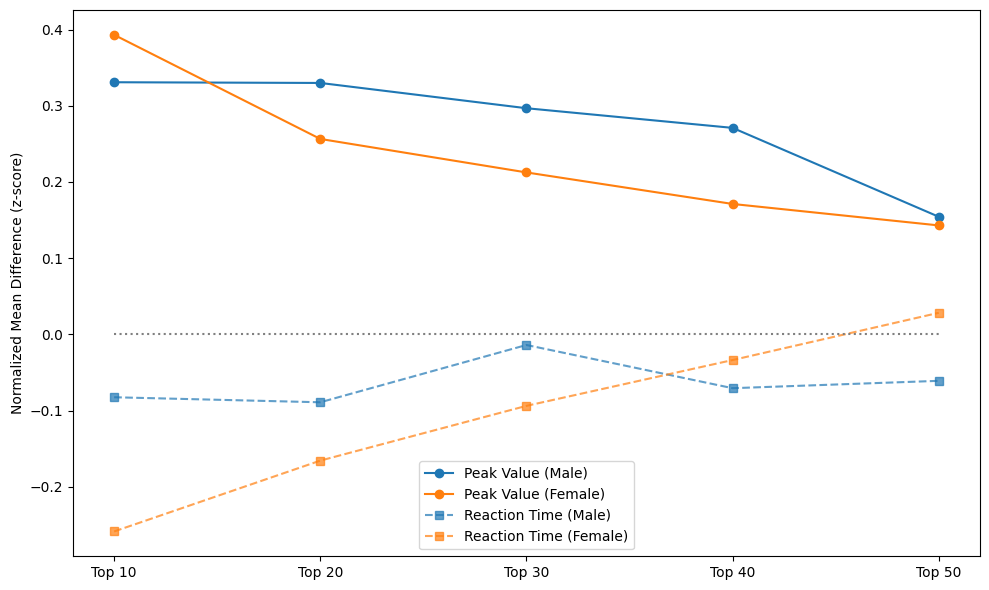

In [12]:
# ...existing code...

import matplotlib.pyplot as plt
import numpy as np

xticks = ['Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']

# Mean differences and stds from your output
peakvalue_means_by_sex = [
    [20.655476, 14.493023],   # Top 10 (male, female)
    [19.729638, 9.344982],    # Top 20
    [18.172272, 7.357317],    # Top 30
    [16.747889, 5.904290],    # Top 40
    [9.874778, 4.909245],     # Top 50
]
peakvalue_stds_by_sex = [
    [62.431973, 36.875188],   # Top 10 (male, female)
    [59.803223, 36.437605],   # Top 20
    [61.234412, 34.614959],   # Top 30
    [61.803132, 34.489655],   # Top 40
    [63.960049, 34.321749],   # Top 50
]

reactiontime_means_by_sex = [
    [-0.152794, -0.530487],   # Top 10 (male, female)
    [-0.155586, -0.330914],   # Top 20
    [-0.025222, -0.183443],   # Top 30
    [-0.128480, -0.063296],   # Top 40
    [-0.118010, 0.052054],    # Top 50
]
reactiontime_stds_by_sex = [
    [1.855569, 2.053325],     # Top 10 (male, female)
    [1.749546, 2.000000],     # Top 20
    [1.829721, 1.959488],     # Top 30
    [1.823701, 1.888092],     # Top 40
    [1.940902, 1.831815],     # Top 50
]

x = np.arange(len(xticks))

# Normalize by standard deviation (z-score)
male_peak_norm = [v[0]/s[0] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
female_peak_norm = [v[1]/s[1] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
male_rt_norm = [v[0]/s[0] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]
female_rt_norm = [v[1]/s[1] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, male_peak_norm, marker='o', label='Peak Value (Male)', color='tab:blue')
ax.plot(x, female_peak_norm, marker='o', label='Peak Value (Female)', color='tab:orange')
ax.plot(x, male_rt_norm, marker='s', linestyle='--', label='Reaction Time (Male)', color='tab:blue', alpha=0.7)
ax.plot(x, female_rt_norm, marker='s', linestyle='--', label='Reaction Time (Female)', color='tab:orange', alpha=0.7)

ax.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)

ax.set_xticks(x)
ax.set_xticklabels(xticks)
ax.set_ylabel('Normalized Mean Difference (z-score)')
ax.legend(loc='lower center')
plt.tight_layout()
plt.show()
# ...existing code...

In [13]:
print("Top 10:")
trend_df = compare_general_trends_by_sex(dfs['C10'], dfs['CM10'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C10'], dfs['CM10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends_by_sex(dfs['C20'], dfs['CM20'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C20'], dfs['CM20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends_by_sex(dfs['C30'], dfs['CM30'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C30'], dfs['CM30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends_by_sex(dfs['C40'], dfs['CM40'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C40'], dfs['CM40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends_by_sex(dfs['C50'], dfs['CM50'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C50'], dfs['CM50'], variables)
print(sig_df)

Top 10:
       sex      variable  mean_difference  df1_median      df1_std  df1_n  \
0   female  reactionTime         0.011010       10.00     1.892497     83   
1   female      peakTime        -0.594663       30.00     0.640489     83   
2   female    difference        -0.605673       20.00     1.988506     83   
3   female     peakValue         0.541328       89.00    33.816709     83   
4   female          PTPA         0.783295       89.20    33.816844     83   
5   female          PTTA         0.027185       77.46    31.559251     83   
6   female           RMS         0.491177       36.77    14.613515     83   
7   female           tau         9.605560      163.28    47.311319     83   
8   female           AUC       562.660608    10342.30  4215.690741     83   
9     male  reactionTime        -0.258896       10.00     2.585757     79   
10    male      peakTime         0.905907       30.00     6.354353     79   
11    male    difference         1.164803       20.00     6.927173  

Trend (Male Exp RT) slope: 0.0062
Trend (Female Exp RT) slope: 0.0705
Trend (Male Ctrl RT) slope: 0.0330
Trend (Female Ctrl RT) slope: -0.0100
Trend (Male Exp Peak) slope: -0.0412
Trend (Female Exp Peak) slope: -0.0585
Trend (Male Ctrl Peak) slope: -0.0101
Trend (Female Ctrl Peak) slope: 0.0116


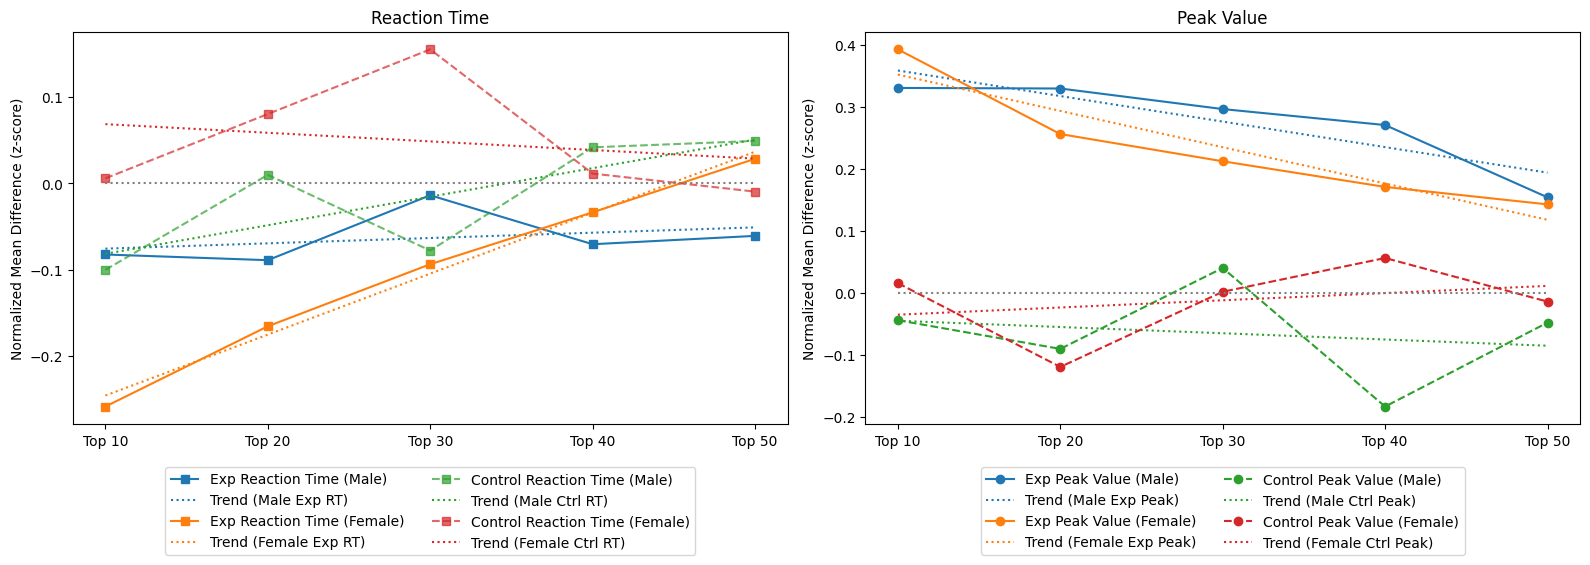

In [29]:
# ...existing code...

xticks = ['Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']

# Experimental (main) results
peakvalue_means_by_sex = [
    [20.655476, 14.493023],   # Top 10 (male, female)
    [19.729638, 9.344982],    # Top 20
    [18.172272, 7.357317],    # Top 30
    [16.747889, 5.904290],    # Top 40
    [9.874778, 4.909245],     # Top 50
]
reactiontime_means_by_sex = [
    [-0.152794, -0.530487],   # Top 10 (male, female)
    [-0.155586, -0.330914],   # Top 20
    [-0.025222, -0.183443],   # Top 30
    [-0.128480, -0.063296],   # Top 40
    [-0.118010, 0.052054],    # Top 50
]

peakvalue_stds_by_sex = [
    [62.431973, 36.875188],   # Top 10 (male, female)
    [59.803223, 36.437605],   # Top 20
    [61.234412, 34.614959],   # Top 30
    [61.803132, 34.489655],   # Top 40
    [63.960049, 34.321749],   # Top 50
]
reactiontime_stds_by_sex = [
    [1.855569, 2.053325],     # Top 10 (male, female)
    [1.749546, 2.000000],     # Top 20
    [1.829721, 1.959488],     # Top 30
    [1.823701, 1.888092],     # Top 40
    [1.940902, 1.831815],     # Top 50
]

# Control results (from your output, mean_difference for peakValue and reactionTime)
control_peakvalue_means_by_sex = [
    [-2.650123, 0.541328],    # Top 10 (male, female)
    [-6.013296, -3.817083],   # Top 20
    [2.595383, 0.064089],     # Top 30
    [-11.038804, 1.765773],   # Top 40
    [-3.096893, -0.464314],   # Top 50
]
control_reactiontime_means_by_sex = [
    [-0.258896, 0.011010],    # Top 10 (male, female)
    [0.020954, 0.154676],     # Top 20
    [-0.159302, 0.247495],    # Top 30
    [0.085236, 0.022068],     # Top 40
    [0.085021, -0.022154],    # Top 50
]

control_peakvalue_stds_by_sex = [
    [60.491278, 33.816709],   # Top 10 (male, female)
    [66.785452, 32.034439],   # Top 20
    [64.140310, 30.420277],   # Top 30
    [60.305098, 31.224891],   # Top 40
    [64.980714, 33.732358],   # Top 50
]
control_reactiontime_stds_by_sex = [
    [2.585757, 1.892497],     # Top 10 (male, female)
    [2.132049, 1.927692],     # Top 20
    [2.048444, 1.595965],     # Top 30
    [2.045039, 1.950466],     # Top 40
    [1.730652, 2.314752],     # Top 50
]

x = np.arange(len(xticks))

# Normalize by standard deviation (z-score)
male_peak_norm = [v[0]/s[0] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
female_peak_norm = [v[1]/s[1] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
male_rt_norm = [v[0]/s[0] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]
female_rt_norm = [v[1]/s[1] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]

# Control normalized
male_peak_control_norm = [v[0]/s[0] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
female_peak_control_norm = [v[1]/s[1] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
male_rt_control_norm = [v[0]/s[0] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]
female_rt_control_norm = [v[1]/s[1] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]


# ...existing code...

xticks = ['Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']

# Experimental (main) results
peakvalue_means_by_sex = [
    [20.655476, 14.493023],   # Top 10 (male, female)
    [19.729638, 9.344982],    # Top 20
    [18.172272, 7.357317],    # Top 30
    [16.747889, 5.904290],    # Top 40
    [9.874778, 4.909245],     # Top 50
]
reactiontime_means_by_sex = [
    [-0.152794, -0.530487],   # Top 10 (male, female)
    [-0.155586, -0.330914],   # Top 20
    [-0.025222, -0.183443],   # Top 30
    [-0.128480, -0.063296],   # Top 40
    [-0.118010, 0.052054],    # Top 50
]

peakvalue_stds_by_sex = [
    [62.431973, 36.875188],   # Top 10 (male, female)
    [59.803223, 36.437605],   # Top 20
    [61.234412, 34.614959],   # Top 30
    [61.803132, 34.489655],   # Top 40
    [63.960049, 34.321749],   # Top 50
]
reactiontime_stds_by_sex = [
    [1.855569, 2.053325],     # Top 10 (male, female)
    [1.749546, 2.000000],     # Top 20
    [1.829721, 1.959488],     # Top 30
    [1.823701, 1.888092],     # Top 40
    [1.940902, 1.831815],     # Top 50
]

# Control results (from your output, mean_difference for peakValue and reactionTime)
control_peakvalue_means_by_sex = [
    [-2.650123, 0.541328],    # Top 10 (male, female)
    [-6.013296, -3.817083],   # Top 20
    [2.595383, 0.064089],     # Top 30
    [-11.038804, 1.765773],   # Top 40
    [-3.096893, -0.464314],   # Top 50
]
control_reactiontime_means_by_sex = [
    [-0.258896, 0.011010],    # Top 10 (male, female)
    [0.020954, 0.154676],     # Top 20
    [-0.159302, 0.247495],    # Top 30
    [0.085236, 0.022068],     # Top 40
    [0.085021, -0.022154],    # Top 50
]

control_peakvalue_stds_by_sex = [
    [60.491278, 33.816709],   # Top 10 (male, female)
    [66.785452, 32.034439],   # Top 20
    [64.140310, 30.420277],   # Top 30
    [60.305098, 31.224891],   # Top 40
    [64.980714, 33.732358],   # Top 50
]
control_reactiontime_stds_by_sex = [
    [2.585757, 1.892497],     # Top 10 (male, female)
    [2.132049, 1.927692],     # Top 20
    [2.048444, 1.595965],     # Top 30
    [2.045039, 1.950466],     # Top 40
    [1.730652, 2.314752],     # Top 50
]

x = np.arange(len(xticks))

# Normalize by standard deviation (z-score)
male_peak_norm = [v[0]/s[0] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
female_peak_norm = [v[1]/s[1] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
male_rt_norm = [v[0]/s[0] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]
female_rt_norm = [v[1]/s[1] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]

# Control normalized
male_peak_control_norm = [v[0]/s[0] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
female_peak_control_norm = [v[1]/s[1] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
male_rt_control_norm = [v[0]/s[0] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]
female_rt_control_norm = [v[1]/s[1] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]


# ...existing code...

def plot_trendline(ax, x, y, color, linestyle, label):
    coeffs = np.polyfit(x, y, 1)
    trend = np.polyval(coeffs, x)
    ax.plot(x, trend, color=color, linestyle=linestyle, alpha=1, label=label)
    print(f"{label} slope: {coeffs[0]:.4f}")
    return coeffs[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Reaction Time Plot ---
axes[0].plot(x, male_rt_norm, marker='s', linestyle='-', label='Exp Reaction Time (Male)', color='tab:blue')
plot_trendline(axes[0], x, male_rt_norm, color='tab:blue', linestyle=':', label='Trend (Male Exp RT)')
axes[0].plot(x, female_rt_norm, marker='s', linestyle='-', label='Exp Reaction Time (Female)', color='tab:orange')
plot_trendline(axes[0], x, female_rt_norm, color='tab:orange', linestyle=':', label='Trend (Female Exp RT)')
axes[0].plot(x, male_rt_control_norm, marker='s', linestyle='--', label='Control Reaction Time (Male)', color='tab:green', alpha=0.7)
plot_trendline(axes[0], x, male_rt_control_norm, color='tab:green', linestyle=':', label='Trend (Male Ctrl RT)')
axes[0].plot(x, female_rt_control_norm, marker='s', linestyle='--', label='Control Reaction Time (Female)', color='tab:red', alpha=0.7)
plot_trendline(axes[0], x, female_rt_control_norm, color='tab:red', linestyle=':', label='Trend (Female Ctrl RT)')
axes[0].plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
axes[0].set_xticks(x)
axes[0].set_xticklabels(xticks)
axes[0].set_ylabel('Normalized Mean Difference (z-score)')
axes[0].set_title('Reaction Time')
axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

# --- Peak Value Plot ---
axes[1].plot(x, male_peak_norm, marker='o', linestyle='-', label='Exp Peak Value (Male)', color='tab:blue')
plot_trendline(axes[1], x, male_peak_norm, color='tab:blue', linestyle=':', label='Trend (Male Exp Peak)')
axes[1].plot(x, female_peak_norm, marker='o', linestyle='-', label='Exp Peak Value (Female)', color='tab:orange')
plot_trendline(axes[1], x, female_peak_norm, color='tab:orange', linestyle=':', label='Trend (Female Exp Peak)')
axes[1].plot(x, male_peak_control_norm, marker='o', linestyle='--', label='Control Peak Value (Male)', color='tab:green')
plot_trendline(axes[1], x, male_peak_control_norm, color='tab:green', linestyle=':', label='Trend (Male Ctrl Peak)')
axes[1].plot(x, female_peak_control_norm, marker='o', linestyle='--', label='Control Peak Value (Female)', color='tab:red')
plot_trendline(axes[1], x, female_peak_control_norm, color='tab:red', linestyle=':', label='Trend (Female Ctrl Peak)')
axes[1].plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
axes[1].set_xticks(x)
axes[1].set_xticklabels(xticks)
axes[1].set_ylabel('Normalized Mean Difference (z-score)')
axes[1].set_title('Peak Value')
axes[1].legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

plt.tight_layout()
plt.show()
# ...existing code...

In [30]:
from scipy.stats import mannwhitneyu

# Test if experimental and control normalized values are significantly different
def print_mwu_test(exp, ctrl, label):
    stat, p = mannwhitneyu(exp, ctrl, alternative='two-sided')
    print(f"{label}: U={stat:.2f}, p={p:.4f}")

print_mwu_test(male_peak_norm, male_peak_control_norm, "Peak Value (Male)")
print_mwu_test(female_peak_norm, female_peak_control_norm, "Peak Value (Female)")
print_mwu_test(male_rt_norm, male_rt_control_norm, "Reaction Time (Male)")
print_mwu_test(female_rt_norm, female_rt_control_norm, "Reaction Time (Female)")

Peak Value (Male): U=25.00, p=0.0079
Peak Value (Female): U=25.00, p=0.0079
Reaction Time (Male): U=8.00, p=0.4206
Reaction Time (Female): U=3.00, p=0.0556
